In [3]:
!pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed

In [4]:
!pip install matplotlib pydeequ

In [135]:
%matplotlib inline

## High Level Stats

In [13]:
df = spark.sql("""select day, hour, count(*) as n_requests
                from wmf.webrequest 
                where year='2023' and month='11' 
            group by day, hour""")

In [14]:
day_hour = df.toPandas()

23/11/15 16:09:17 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/15 16:09:39 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


In [15]:
day_hour.shape

(351, 3)

### Distinct IPs stats on en.wikipedia.org

In [16]:
query = """SELECT ip,
  MIN(dt) as first_seen_timestamp,
  MAX(dt)  as last_seen_timestamp,
  COUNT(*) as n_requests,
  COUNT(DISTINCT uri_path) as uri_path
FROM
  wmf.webrequest
WHERE
  year = '2023'
  AND month = '11'
  AND day = '07'
--  AND hour = '13'
  AND uri_host = "en.wikipedia.org"
  AND http_status = 200
GROUP by ip
ORDER BY n_requests DESC
"""

In [17]:
df = spark.sql(query)

# Deequ analyzer

In [1]:
import os
spark_version = "3.1.2" # required by pydeequ
os.environ['SPARK_VERSION'] = spark_version

In [2]:
import wmfdata as wmf
import pydeequ
from pydeequ.analyzers import *
extra_settings = {"spark.jars.packages": pydeequ.deequ_maven_coord, "spark.jars.excludes": pydeequ.f2j_maven_coord}
spark = wmf.spark.create_session(extra_settings=extra_settings)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3
:: loading settings :: url = jar:file:/opt/conda-analytics/lib/python3.10/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/gmodena/.ivy2/cache
The jars for the packages stored in: /home/gmodena/.ivy2/jars
com.amazon.deequ#deequ added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ba6b34fa-b0c1-419c-8745-a1d1705edba4;1.0
	confs: [default]
	found com.amazon.deequ#deequ;2.0.0-spark-3.1 in central
	found org.scalanlp#breeze_2.12;0.13.2 in central
	found org.scalanlp#breeze-macros_2.12;0.13.2 in central
	found org.scala-lang#scala-reflect;2.12.1 in central
	found com.github.fommil.netlib#core;1.1.2 in central
	found net.sf.opencsv#opencsv;2.3 in central
	found com.github.rwl#jtransforms;2.4.0 in central
	found junit#junit;4.8.2 in central
	found org.apache.commons#commons-math3;3.2 in central
	found org.spire-math#spire_2.12;0.13.0 in central
	found org.spire-math#spire-macros_2.12;0.13.0 in central
	found org.typelevel#machinist_2.12;0.6.1 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-compat_2.12;1.1.1

In [3]:
print(spark.conf.get("spark.jars.packages"), spark.conf.get("spark.jars.excludes"))

com.amazon.deequ:deequ:2.0.0-spark-3.1 net.sourceforge.f2j:arpack_combined_all


In [4]:
df = spark.sql("""select * 
                from wmf.webrequest 
                where year='2023' and month='11' and day='07'""")

In [5]:
type(df), type(spark)

(pyspark.sql.dataframe.DataFrame, pyspark.sql.session.SparkSession)

In [6]:
analysisResult = ( AnalysisRunner(spark) 
                    .onData(df) 
                    .addAnalyzer(Size()) 
                    .addAnalyzer(Completeness("user_agent")) \
                    .run() )

23/11/15 16:23:07 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


## Profile columns

This block will perform some automated data analysis and generate summary stats on the input dataframe.

In [7]:
from pydeequ.profiles import *
result = ColumnProfilerRunner(spark) \
    .onData(df.select("hour", "hostname", "user_agent", "uri_host")) \
    .run()

for col, profile in result.profiles.items():
    print(profile)

23/11/15 16:24:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


NumericProfiles for column: hour: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 25,
    "dataType": "Integral",
    "isDataTypeInferred": false,
    "typeCounts": {},
    "histogram": [
        [
            "12",
            538866030,
            0.04605732582013916
        ],
        [
            "8",
            448677203,
            0.03834881209090082
        ],
        [
            "19",
            569394533,
            0.04866662225226367
        ],
        [
            "23",
            405186884,
            0.03463165851155051
        ],
        [
            "4",
            358467342,
            0.030638500568264167
        ],
        [
            "15",
            584827481,
            0.04998568909787883
        ],
        [
            "11",
            521087998,
            0.04453782270307524
        ],
        [
            "9",
            469776360,
            0.040152174511945006
        ],
        [
            "22",
            465440

Example of metrics reporting:
 - counts the number of rows (dataset level).
 - computes the completeness (no NULL values) on the `user_agent` column.

In [8]:
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-------+----------+------------+---------------+
| entity|  instance|        name|          value|
+-------+----------+------------+---------------+
|Dataset|         *|        Size|1.1699898342E10|
| Column|user_agent|Completeness|            1.0|
+-------+----------+------------+---------------+



## Automate data analysis and suggest constraints.

The output is quite verbose, and did no generate any insightful constraint IMHO. Most of it are things I'd expect. The automation step could be nice, 
if we were to scaffold data unit tests in a cookiecutter kind of template.

In [9]:
from pydeequ.suggestions import *

suggestionResult = ConstraintSuggestionRunner(spark) \
             .onData(df.select("sequence")) \
             .addConstraintRule(DEFAULT()) \
             .run()

# Constraint Suggestions in JSON format
print(suggestionResult)

{'constraint_suggestions': [{'constraint_name': 'CompletenessConstraint(Completeness(sequence,None))', 'column_name': 'sequence', 'current_value': 'Completeness: 1.0', 'description': "'sequence' is not null", 'suggesting_rule': 'CompleteIfCompleteRule()', 'rule_description': 'If a column is complete in the sample, we suggest a NOT NULL constraint', 'code_for_constraint': '.isComplete("sequence")'}, {'constraint_name': "ComplianceConstraint(Compliance('sequence' has no negative values,sequence >= 0,None))", 'column_name': 'sequence', 'current_value': 'Minimum: 0.0', 'description': "'sequence' has no negative values", 'suggesting_rule': 'NonNegativeNumbersRule()', 'rule_description': 'If we see only non-negative numbers in a column, we suggest a corresponding constraint', 'code_for_constraint': '.isNonNegative("sequence")'}]}


## sequence number validation

This sections reproduces the seuquence number validation logic from https://github.com/wikimedia/analytics-refinery/blob/master/hql/webrequest/generate_sequence_statistics_hourly.hql.

In [12]:
import pyspark.sql.functions as F

In [13]:
_tmp_df = df.select("hour", "hostname", "sequence").where(F.col("sequence") > 0)

In [14]:
varnish_restarts = _tmp_df.select("hour", "hostname", "sequence").where(F.col("sequence") < 1).groupBy("hour", "hostname", "sequence").count()

In [15]:
varnish_restarts.show()

+----+--------+--------+-----+
|hour|hostname|sequence|count|
+----+--------+--------+-----+
+----+--------+--------+-----+



#### Generate sequence stats

In [20]:
# Calculate expected_sequence as max(sequence) - min(sequence)
# Calculate the difference between the number of rows and expected_sequence
sequence_number_diff_df = _tmp_df \
    .groupBy("hour", "hostname") \
    .agg(
        F.count("sequence").alias("num_rows"),
        F.max("sequence").alias("max_sequence"),
        F.min("sequence").alias("min_sequence")
    ) \
    .withColumn("expected_sequence", F.col("max_sequence") - F.col("min_sequence")) \
    .withColumn("difference", F.abs(F.col("num_rows") - F.col("expected_sequence")))

sequence_number_diff_df.show()

+----+------------------+--------+------------+------------+-----------------+----------+
|hour|          hostname|num_rows|max_sequence|min_sequence|expected_sequence|difference|
+----+------------------+--------+------------+------------+-----------------+----------+
|  18|cp2027.codfw.wmnet| 5332503|  1987120065|  1981787563|          5332502|         1|
|  21|cp5021.eqsin.wmnet| 2992399|  3875099587|  3872107189|          2992398|         1|
|   9|cp1087.eqiad.wmnet| 3138320|  3033019941|  3029881622|          3138319|         1|
|   7|cp4043.ulsfo.wmnet| 2974634|  1285079288|  1282104655|          2974633|         1|
|   3|cp2041.codfw.wmnet| 5145484|  1877999120|  1872853637|          5145483|         1|
|  13|cp4045.ulsfo.wmnet|  926475|   967627188|   966700714|           926474|         1|
|  10|cp5028.eqsin.wmnet| 4392473|  1604042366|  1599649894|          4392472|         1|
|   0|cp2034.codfw.wmnet| 3446762|  1042160331|  1038713570|          3446761|         1|
|  16|cp20

Some EDA on sequence delta distributions (errors rates?).

In [21]:
_tmp_df = sequence_number_diff_df.toPandas()

In [31]:
print(f"""records={_tmp_df.shape[0]}, candidate_outliers={_tmp_df[_tmp_df['difference'] > 1]['difference'].shape[0]}""")

records=2649, candidate_outliers=100


In [23]:
_tmp_df.head(1).T

0
hour                               18
hostname           cp2027.codfw.wmnet
num_rows                      5332503
max_sequence               1987120065
min_sequence               1981787563
expected_sequence             5332502
difference                          1

<Axes: >

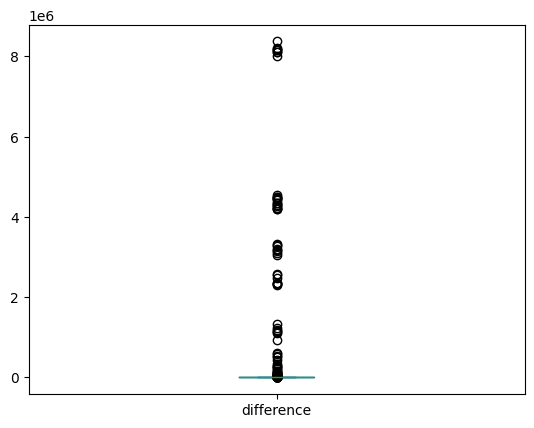

In [32]:
_tmp_df["difference"].plot(kind="box")

<Axes: title={'center': 'Distribution of outliers'}>

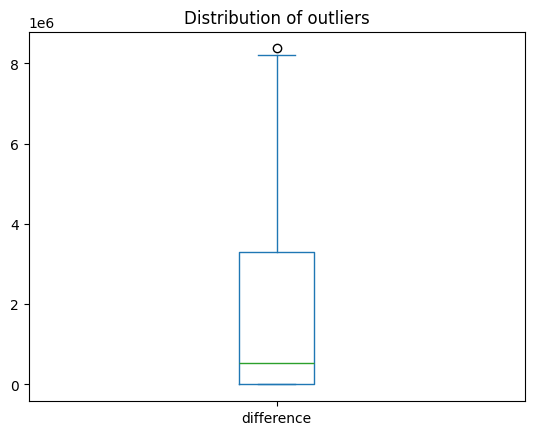

In [33]:
_tmp_df[_tmp_df["difference"] > 1]["difference"].plot(kind="box", title="Distribution of outliers")

<Axes: ylabel='Frequency'>

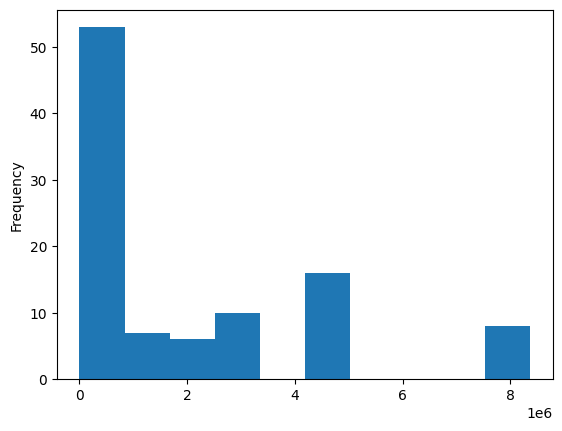

In [34]:
_tmp_df[_tmp_df["difference"] > 1]["difference"].plot(kind="hist")

TODO: plot sequence validation deltas per host?

# Some more profiling

Profile `sequence_number_diff_df`. Again, nothing insightful.

In [36]:
from pydeequ.profiles import *
result = ColumnProfilerRunner(spark) \
    .onData(sequence_number_diff_df) \
    .run()

for col, profile in result.profiles.items():
    print(profile)

NumericProfiles for column: min_sequence: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 2582,
    "dataType": "Integral",
    "isDataTypeInferred": false,
    "typeCounts": {},
    "histogram": null,
    "kll": "None",
    "mean": 1950088175.756512,
    "maximum": 6560130942.0,
    "minimum": 1.0,
    "sum": 5165783577579.0,
    "stdDev": 1481042370.6372406,
    "approxPercentiles": []
}
NumericProfiles for column: expected_sequence: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 2536,
    "dataType": "Integral",
    "isDataTypeInferred": false,
    "typeCounts": {},
    "histogram": null,
    "kll": "None",
    "mean": 4347855.34805587,
    "maximum": 18842697.0,
    "minimum": 334.0,
    "sum": 11517468817.0,
    "stdDev": 3961382.7297591125,
    "approxPercentiles": []
}
StandardProfiles for column: hostname: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 113,
    "dataType": "String",
    "isDataTypeInferred": false,
    "typeCounts"

In [37]:
from pydeequ.suggestions import *

suggestionResult = ConstraintSuggestionRunner(spark) \
             .onData(sequence_number_diff_df) \
             .addConstraintRule(DEFAULT()) \
             .run()


In [38]:
import json
print(json.dumps(suggestionResult))

{"constraint_suggestions": [{"constraint_name": "CompletenessConstraint(Completeness(min_sequence,None))", "column_name": "min_sequence", "current_value": "Completeness: 1.0", "description": "'min_sequence' is not null", "suggesting_rule": "CompleteIfCompleteRule()", "rule_description": "If a column is complete in the sample, we suggest a NOT NULL constraint", "code_for_constraint": ".isComplete(\"min_sequence\")"}, {"constraint_name": "ComplianceConstraint(Compliance('min_sequence' has no negative values,min_sequence >= 0,None))", "column_name": "min_sequence", "current_value": "Minimum: 1.0", "description": "'min_sequence' has no negative values", "suggesting_rule": "NonNegativeNumbersRule()", "rule_description": "If we see only non-negative numbers in a column, we suggest a corresponding constraint", "code_for_constraint": ".isNonNegative(\"min_sequence\")"}, {"constraint_name": "UniquenessConstraint(Uniqueness(List(min_sequence),None))", "column_name": "min_sequence", "current_valu

### Count of requests per user agent, project, country and wiki version (limit to top x)

Generate and store temp tables for candidate metrics. Omit output, it might leak PII.

In [ ]:
ua_counts = df.select("hour", "user_agent").groupBy("hour", "user_agent").count()

In [ ]:
wiki_count =  df.select("hour", "uri_host").groupBy("hour", "uri_host").count()

# Save data

In [60]:
result_df.write.parquet("wip/webrequests/stats/sequence")

In [ ]:
wiki_count.coalesce(1).write.parquet("wip/webrequests/stats/wiki_count")

In [62]:
ua_counts.coalesce(1).write.parquet("wip/webrequests/stats/ua_counts")

# Metrics repository

Experiments with the metrics repository API. Sample data and store metrics. Output is omitted because it might leak PII.
Deequ offers many more metrics than the ones reported here. See https://github.com/awslabs/deequ/tree/54c5e48c21ebbe30a75c142e4621d5ca4669ab48/src/main/scala/com/amazon/deequ/analyzers


df.select("user_agent", "hostname").where(F.col("hour") == "15").show(10)

##### Keep a file for count metrics, and a file for sequence validation counts.

## Count metrics

In [108]:
from pydeequ.repository import *
from pydeequ.analyzers import *

metrics_file = FileSystemMetricsRepository.helper_metrics_file(spark, 'webrequests-summary-stats.json')
repository = FileSystemMetricsRepository(spark, metrics_file)

# Analyzer enforce a schema (sort of) on the repository
analyzers = [Size(), ApproxCountDistinct('user_agent'), ApproxCountDistinct('hostname')]

repository.load() \
    .before(ResultKey.current_milli_time()) \
    .forAnalyzers(analyzers)

for hour in ("01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "00"):

    key_tags = {'metrics_type': 'WebrequestsSummaryStats', 'date': '2023-11-07', 'hour': hour}
    resultKey = ResultKey(spark, ResultKey.current_milli_time(), key_tags) # Key the record using a monotonically increasing id (timestamp)

    countsAnalysisResult = AnalysisRunner(spark) \
    .onData(df.select("user_agent", "hostname").where(F.col("hour") == hour)) \
    .addAnalyzer(Size()) \
    .addAnalyzer(ApproxCountDistinct('user_agent')) \
    .addAnalyzer(ApproxCountDistinct('hostname')) \
    .useRepository(repository) \
    .saveOrAppendResult(resultKey) \
    .run()

Data is stored as json in HDFS. Each item is a metric

In [109]:
!hadoop fs -cat {repository.path}

[
  {
    "resultKey": {
      "dataSetDate": 1700489237985,
      "tags": {
        "date": "2023-11-07",
        "hour": "01",
        "metrics_type": "WebrequestsSummaryStats"
      }
    },
    "analyzerContext": {
      "metricMap": [
        {
          "analyzer": {
            "analyzerName": "Size"
          },
          "metric": {
            "metricName": "DoubleMetric",
            "entity": "Dataset",
            "instance": "*",
            "name": "Size",
            "value": 3.88760675E8
          }
        },
        {
          "analyzer": {
            "analyzerName": "ApproxCountDistinct",
            "column": "user_agent"
          },
          "metric": {
            "metricName": "DoubleMetric",
            "entity": "Column",
            "instance": "user_agent",
            "name": "ApproxCountDistinct",
            "value": 679719.0
          }
        },
        {
          "analyzer": {
            "analyzerName": "ApproxCountDistinct",
            "column

Extract the metrics as DataFrame, and store it to HDFS for dashboarding.

In [110]:
result_count_metrep_df = repository.load() \
    .before(ResultKey.current_milli_time()) \
    .forAnalyzers(analyzers) \
    .getSuccessMetricsAsDataFrame()

In [111]:
result_count_metrep_df.show(truncate=False)

+-------+----------+-------------------+------------+-------------+----------+----+-----------------------+
|entity |instance  |name               |value       |dataset_date |date      |hour|metrics_type           |
+-------+----------+-------------------+------------+-------------+----------+----+-----------------------+
|Dataset|*         |Size               |3.88760675E8|1700489237985|2023-11-07|01  |WebrequestsSummaryStats|
|Column |user_agent|ApproxCountDistinct|679719.0    |1700489237985|2023-11-07|01  |WebrequestsSummaryStats|
|Column |hostname  |ApproxCountDistinct|111.0       |1700489237985|2023-11-07|01  |WebrequestsSummaryStats|
|Dataset|*         |Size               |3.89454101E8|1700489262318|2023-11-07|02  |WebrequestsSummaryStats|
|Column |user_agent|ApproxCountDistinct|660600.0    |1700489262318|2023-11-07|02  |WebrequestsSummaryStats|
|Column |hostname  |ApproxCountDistinct|111.0       |1700489262318|2023-11-07|02  |WebrequestsSummaryStats|
|Dataset|*         |Size    

In [115]:
result_count_metrep_df.write.mode("overwrite").parquet('wip/webrequests/metrics_repo/')

In [118]:
result_count_metrep_df.write.mode("overwrite").saveAsTable("gmodena.deequ_webrequests_metrics")

## Sequence validation

In [125]:
from pydeequ.repository import *
from pydeequ.analyzers import *

# Maybe we could share a repo with multiple metrics files?
metrics_file = FileSystemMetricsRepository.helper_metrics_file(spark, 'webrequests-sequence-validation.json')
repository = FileSystemMetricsRepository(spark, metrics_file)

# Analyzer enforce a schema (sort of) on the repository
analyzers = [Size(), Minimum('difference'), Maximum('difference'), Mean('difference')]

repository.load() \
    .before(ResultKey.current_milli_time()) \
    .forAnalyzers(analyzers)


for hour in range(0,24):
    key_tags = {'metrics_type': 'WebrequestsSequenceValidation', 'date': '2023-11-07', 'hour': str(hour).zfill(2)}
    resultKey = ResultKey(spark, ResultKey.current_milli_time(), key_tags) # Key the record using a monotonically increasing id (timestamp)

    countsAnalysisResult = AnalysisRunner(spark) \
    .onData(sequence_number_diff_df.select("hostname", "difference").where(F.col("hour") == hour)) \
    .addAnalyzer(Size()) \
    .addAnalyzer(Minimum('difference')) \
    .addAnalyzer(Maximum('difference')) \
    .addAnalyzer(Mean('difference')) \
    .useRepository(repository) \
    .saveOrAppendResult(resultKey) \
    .run()

In [126]:
!hadoop fs -cat {repository.path}

[
  {
    "resultKey": {
      "dataSetDate": 1700491167431,
      "tags": {
        "date": "2023-11-07",
        "hour": "00",
        "metrics_type": "WebrequestsSequenceValidation"
      }
    },
    "analyzerContext": {
      "metricMap": [
        {
          "analyzer": {
            "analyzerName": "Size"
          },
          "metric": {
            "metricName": "DoubleMetric",
            "entity": "Dataset",
            "instance": "*",
            "name": "Size",
            "value": 110.0
          }
        },
        {
          "analyzer": {
            "analyzerName": "Minimum",
            "column": "difference"
          },
          "metric": {
            "metricName": "DoubleMetric",
            "entity": "Column",
            "instance": "difference",
            "name": "Minimum",
            "value": 0.0
          }
        },
        {
          "analyzer": {
            "analyzerName": "Maximum",
            "column": "difference"
          },
          "me

In [128]:
result_sequence_metrep_df = repository.load() \
    .before(ResultKey.current_milli_time()) \
    .forAnalyzers(analyzers) \
    .getSuccessMetricsAsDataFrame()

In [129]:
result_sequence_metrep_df.show(truncate=False)

+-------+----------+-------+------------------+-------------+----------+----+-----------------------------+
|entity |instance  |name   |value             |dataset_date |date      |hour|metrics_type                 |
+-------+----------+-------+------------------+-------------+----------+----+-----------------------------+
|Dataset|*         |Size   |110.0             |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Minimum|0.0               |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Maximum|1.0               |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Mean   |0.990909090909091 |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Dataset|*         |Size   |110.0             |1700491190510|2023-11-07|01  |WebrequestsSequenceValidation|
|Column |difference|Minimum|1.0               |1700491190510|2023-11-07|01  |WebrequestsSequenceValidation|
|Column |difference|Maximum|

In [130]:
result_sequence_metrep_df.write.mode("overwrite").parquet('wip/webrequests/sequence_validation_repo/')

In [131]:
result_sequence_metrep_df.show(truncate=False)

+-------+----------+-------+------------------+-------------+----------+----+-----------------------------+
|entity |instance  |name   |value             |dataset_date |date      |hour|metrics_type                 |
+-------+----------+-------+------------------+-------------+----------+----+-----------------------------+
|Dataset|*         |Size   |110.0             |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Minimum|0.0               |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Maximum|1.0               |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Column |difference|Mean   |0.990909090909091 |1700491167431|2023-11-07|00  |WebrequestsSequenceValidation|
|Dataset|*         |Size   |110.0             |1700491190510|2023-11-07|01  |WebrequestsSequenceValidation|
|Column |difference|Minimum|1.0               |1700491190510|2023-11-07|01  |WebrequestsSequenceValidation|
|Column |difference|Maximum|

In [133]:
result_sequence_metrep_df.write.mode("overwrite").saveAsTable("gmodena.deequ_webrequests_sequence_validation")

`_tmp_seq_df = result_sequence_metrep_df.toPandas()` fails with:

```---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[137], line 1
----> 1 _tmp_seq_df = result_sequence_metrep_df.toPandas()

File ~/.conda/envs/2023-11-08T11.16.46_gmodena/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:67, in PandasConversionMixin.toPandas(self)
     64 import numpy as np
     65 import pandas as pd
---> 67 timezone = self.sql_ctx._conf.sessionLocalTimeZone()
     69 if self.sql_ctx._conf.arrowPySparkEnabled():
     70     use_arrow = True

AttributeError: 'RuntimeConfig' object has no attribute 'sessionLocalTimeZone'
```